## Load modules and data

In [0]:
#Base
import numpy as np
import pandas as pd
import scipy.spatial
import dataclasses
import os, sys, time
import json
import itertools
from tqdm import tqdm
import pdb

#Plot 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
default_figsize = [5, 5]
plt.rcParams['figure.figsize'] = default_figsize
color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

# EM-coregistration Github
use_cuda = True
if use_cuda:
    import cupy as cp
    to_cpu = cp.asnumpy
    cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
else:
    cp = np
    to_cpu = lambda x: x
import open3d as o3
from probreg import cpd, bcpd, callbacks, gmmtree
from probreg.cpd import registration_cpd
import open3d as o3d
import utils
import time
import transforms3d as t3d
import copy
from probreg import filterreg
from probreg import features
from probreg import math_utils

#Cave
import requests
from requests.auth import HTTPBasicAuth
import caveclient

#V1DD
from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2
em_final_voxel_size = np.array([4.85, 4.85, 45])

PlotDir = '/home/david.wyrick/projects/V1DD/coregistration/plots'

# TODO implement this as a utility
def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
#Read in point clouds
data = np.load('/home/david.wyrick/projects/V1DD/coregistration/point_clouds.npz')

#Get nucleus volumes
vol_mask = data['vol_mask']
nucleus_vols = data['nucleus_vols']

#Get em ids and 2p names
ids_em = data['nucleus_ids']
ids_2p = data['all_roi_chasenames']

#Get coregistered points
coreg_pts_2p = data['coreg_pts_2p']
coreg_pts_em = data['coreg_pts_em']
coreg_2p_ids = data['coreg_2p_ids']
coreg_em_ids = data['coreg_em_ids']
idx_2p = data['idx_2p']
idx_em = data['idx_em']

#Get point clouds
point_set_em = data['nucleus_pts_microns']
point_set_2p = data['all_roi_func_coreg_pts']

# point_set_em = data['nucleus_pts']
all_roi_raw_center_pts = data['all_roi_raw_center_pts']
point_set_em.shape, point_set_2p.shape

((16568, 3), (2710, 3))

In [73]:
planes = all_roi_raw_center_pts[:,2]
planes


array([0., 0., 0., ..., 5., 5., 5.])

In [74]:
point_set_2p_new = point_set_2p.copy()
point_set_2p_new[:,1] = point_set_2p[:,2]
point_set_2p_new[:,2] = point_set_2p[:,1]
point_set_2p_new[0]

array([343.09136814, 267.        , 271.41003318])

In [1]:
# em_client = EMClient("v1dd",server_address="https://globalv1.em.brain.allentech.org")
# base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
# ophys_client = OPhysClient(base_folder)

# em_client = EMClient()

# ## Load EM data
# nucleus_table = em_client.query_table('nucleus_detection_v0')

# #Extract point position 
# nucleus_pts = np.array([i for i in nucleus_table.pt_position])
# nucleus_ids = np.array([i for i in nucleus_table.id])

# # matrix that describes the transformation from the input functional space (in pixels) to the coregistration space (in microns) and its inverse
# func_raw2coreg_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/func_raw2coreg_tform.npy"
# func_raw2coreg_tform = np.load(func_raw2coreg_tform_fn)
# func_coreg2raw_tform = np.linalg.inv(func_raw2coreg_tform)

# # matrix that describes the transformation from the input EM coregistration space (in microns) to the final EM space (in voxels)
# em_coreg2final_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/em_coreg2final_tform.npy"
# em_coreg2final_tform = np.load(em_coreg2final_tform_fn)
# em_final2coreg_tform = np.linalg.inv(em_coreg2final_tform)

In [5]:
# coreg_df = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_table_20230612.csv',index_col=0)
# coreg_df = coreg_df.convert_dtypes()
# coreg_cells_df = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_cells_table_20230612.csv',index_col=0)
# coreg_cells_df = coreg_cells_df.convert_dtypes()

# ptset_mask = []
# for label in coreg_df['label'].values:
#     if 'Pt' in label:
#         ptset_mask.append(True)
#     else:
#         ptset_mask.append(False)
# ptset_mask = np.array(ptset_mask)


# transform_list = [
#     {
#         "name": "PolynomialModel",
#         "order": 1,
#         "regularization": [0, 0, 0, 0]
#     },
#     {
#         "name": "ChunkedModel",
#         "order": 1,
#         "nchunks": 3,
#         "axis": 0
#     },
#     {
#         "name": "SplineModel",
#         "ncntrl": [3, 3, 3],
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
#     },
#     {
#         "name": "SplineModel",
#         "ncntrl": [5, 5, 5],
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
#     },
#     {
#         "name": "SplineModel",
#         "ncntrl": [10, 10, 10],
#          "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
#     },
#     {
#         "name": "SplineModel",
#         "ncntrl": [10, 10, 10],
#          "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
#     },
#     {
#         "name": "SplineModel",
#         "ncntrl": [12, 12, 12],
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
#     },
#     {
#         "name": "SplineModel",
#         "ncntrl": [12, 12, 12],
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
#     },
#     {
#         "name": "SplineModel",
#         "voronoi_cntrl": True,
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
#     },
#     {
#         "name": "SplineModel",
#         "src_is_cntrl": True,
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
#     },
#     {
#         "name": "SplineModel",
#         "src_is_cntrl": True,
#         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
#     },
        
# ]

# transform_obj = {
#         "name": "TransformList",
#         "transforms": transform_list
#     }

# func_coreg_pts = np.array(coreg_df[["optx", "opty", "optz"]],dtype=float)
# em_coreg_pts = np.array(coreg_df[["emx", "emy", "emz"]],dtype=float)
# point_types = list(coreg_df['type'].values)

# # func_coreg_pts = func_coreg_pts[ptset_mask]
# # em_coreg_pts = em_coreg_pts[ptset_mask]

# nPts = len(func_coreg_pts)
# # estimate transformation
# tform = coregister.transform.Transform(json=transform_obj)
# tform.estimate(func_coreg_pts, em_coreg_pts)
# # tform.estimate(func_coreg_pts[ptset_mask], em_coreg_pts[ptset_mask])
# nPts



,ophys_session_id,ophys_plane,ophys_roi,russel_key,chase_key,em_id,pt_position,em_final_em_nm,em_final_em_nm_transformed,em_coreg,...,coreg_disp,label,flag,emx,emy,emz,optx,opty,optz,type
0,M409828_13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,[635.2803438 328.9787035 226.841928 ],...,<NA>,Pt-0,True,635.280344,328.978703,226.841928,119.337257,469.505399,75.311303,Blood-vessel
1,M409828_13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,[698.7502361 322.6814042 275.3772396],...,<NA>,Pt-1,True,698.750236,322.681404,275.37724,163.517246,516.582437,75.009528,Blood-vessel
2,M409828_13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,[708.2556528 330.1921791 355.5080331],...,<NA>,Pt-2,True,708.255653,330.192179,355.508033,176.817332,600.794368,93.11608,Blood-vessel
3,M409828_13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,[903.3052035 379.6234028 346.6016709],...,<NA>,Pt-3,True,903.305203,379.623403,346.601671,381.113136,563.926411,130.782925,Blood-vessel
4,M409828_13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,[637.073622 448.602289 212.6652757],...,<NA>,Pt-4,True,637.073622,448.602289,212.665276,140.82251,434.169473,181.844683,Blood-vessel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,M409828_13,1,67,plane0_roi_0067,M409828_13_1_67,352169,[897754 583940 257715],"[897750.0, 583938.0, 257715.0]",<NA>,[808.35892158 539.55288115 257.715 ],...,0.004472,Test-set-15,True,808.358922,539.552881,257.715,313.241206,444.074177,267.0,Cell
176,M409828_13,3,250,plane2_roi_0250,M409828_13_3_250,279007,[835209 593174 319005],"[835209.0, 593172.0, 319005.0]",<NA>,[745.81391217 548.78688254 319.005 ],...,0.002,Test-set-17,True,745.813912,548.786883,319.005,235.945224,515.418663,299.0,Cell
177,M409828_13,1,6,plane0_roi_0006,M409828_13_1_6,276453,[760402 584095 208350],"[761231.97734375, 584861.0453125, 207833.57666...",<NA>,[671.00690092 539.70788117 208.35 ],...,1.241926,Test-set-18,True,671.006901,539.707881,208.35,174.675411,406.782794,267.0,Cell
178,M409828_13,1,22,plane0_roi_0022,M409828_13_1_22,276650,[864930 596744 206460],"[865263.7953125, 597459.375, 206643.4716796875]",<NA>,[775.53491664 552.35688307 206.46 ],...,0.810458,Test-set-19,True,775.534917,552.356883,206.46,287.807415,396.922567,267.0,Cell


## Bunny example

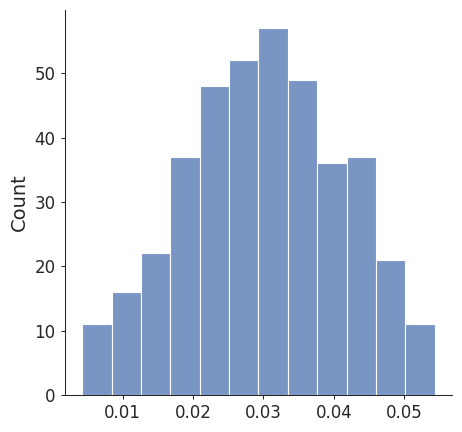

In [5]:
use_cuda=False

ExDir ='/home/david.wyrick/Git/probreg/examples'

source = o3.io.read_point_cloud(os.path.join(ExDir,'bunny.pcd'))
source.remove_non_finite_points()
target = copy.deepcopy(source)

# transform target point cloud
th = np.deg2rad(30.0)
target.transform(np.array([[np.cos(th), -np.sin(th), 0.0, 0.0],
                           [np.sin(th), np.cos(th), 0.0, 0.0],
                           [0.0, 0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0, 1.0]]))
# source = source.voxel_down_sample(voxel_size=0.005)
# target = target.voxel_down_sample(voxel_size=0.005)

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'nonrigid',use_cuda=use_cuda,maxiter=5000,beta=100,lmd=1000)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points) - to_cpu(result.points),axis=1)
sns.histplot(residuals)

# draw result
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0, 1])
o3.visualization.draw_geometries([source, target, result])

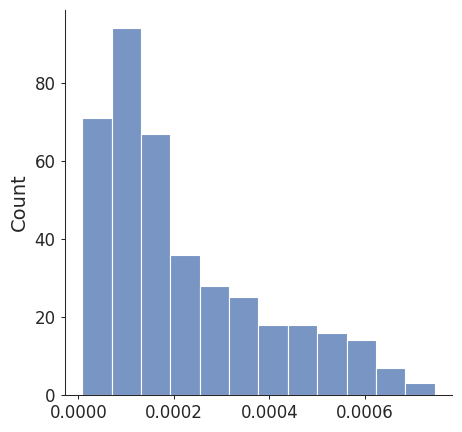

In [6]:
indy = np.random.choice(np.arange(397),10,replace=False)
use_cuda=False

ExDir ='/home/david.wyrick/Git/probreg/examples'

source = o3.io.read_point_cloud(os.path.join(ExDir,'bunny.pcd'))
source.remove_non_finite_points()
target = copy.deepcopy(source)

# transform target point cloud
th = np.deg2rad(30.0)
target.transform(np.array([[np.cos(th), -np.sin(th), 0.0, 0.0],
                           [np.sin(th), np.cos(th), 0.0, 0.0],
                           [0.0, 0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0, 1.0]]))
# source = source.voxel_down_sample(voxel_size=0.005)
# target = target.voxel_down_sample(voxel_size=0.005)

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'nonrigid_constrained',idx_source=indy,idx_target=indy,use_cuda=use_cuda,maxiter=5000)#,beta=10,lmd=100)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points) - to_cpu(result.points),axis=1)
sns.histplot(residuals)

# draw result
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0, 1])
o3.visualization.draw_geometries([source, target, result])

## CPD 2D

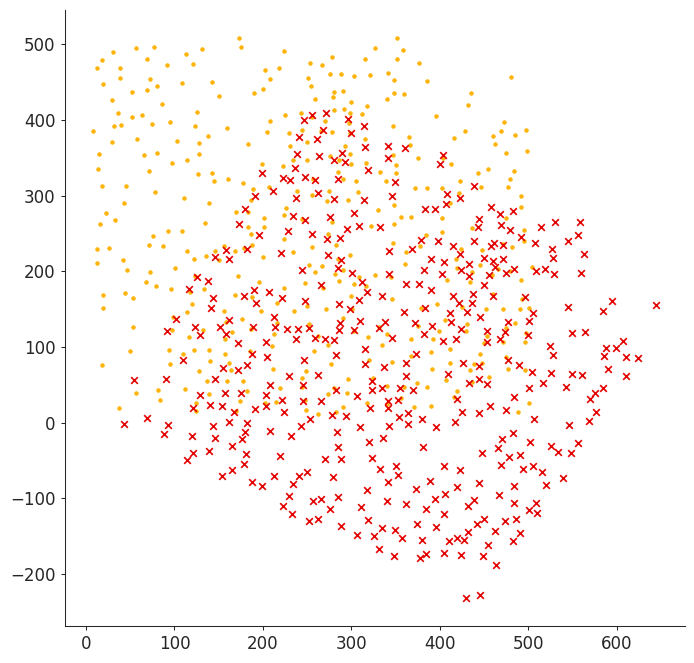

In [20]:
indy = np.where(planes == 0)[0]
ophys_xy = all_roi_raw_center_pts[indy,:2]
ophys_xy.shape

import math
angle_rad = math.radians(30)

# Define the rotation matrix
rotation_matrix = np.array([[math.cos(angle_rad), -math.sin(angle_rad)],
                            [math.sin(angle_rad), math.cos(angle_rad)]])
ophys_xy_rotated = ophys_xy @ rotation_matrix

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(ophys_xy[:,0],ophys_xy[:,1],marker='.',color=cc[0])
ax.scatter(ophys_xy_rotated[:,0],ophys_xy_rotated[:,1],marker='x',color=cc[1])

In [22]:
source = ophys_xy_rotated
target = ophys_xy

use_cuda= False #Cuda does not work in 2D ??
if use_cuda:
    source = cp.asarray(source, dtype=cp.float32)
    target = cp.asarray(target, dtype=cp.float32)

tf_param, _, _ = cpd.registration_cpd(source, target, 'rigid',use_cuda=use_cuda,maxiter=1000)

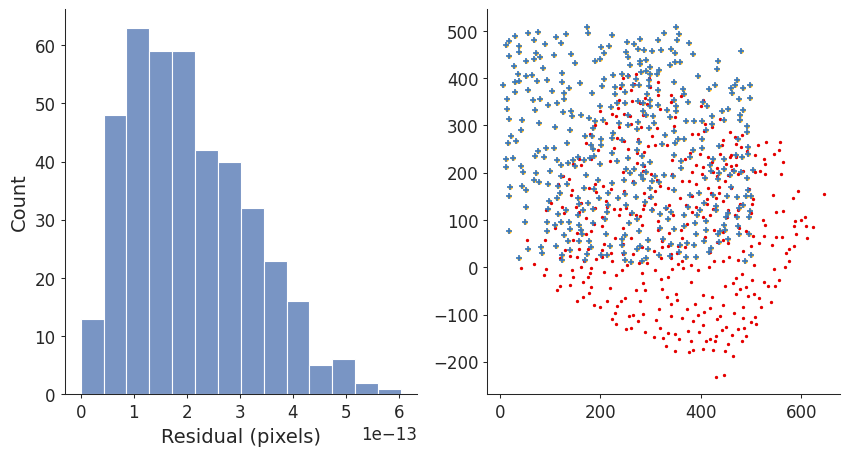

In [23]:
#Transform EM data
result = tf_param.transform(source)

#Plot residuals
residuals = np.linalg.norm(to_cpu(target) - to_cpu(result),axis=1)

fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.histplot(residuals,ax=axes[0])
axes[0].set_xlabel('Residual (pixels)')

result = to_cpu(result)
ax = axes[1]
ax.scatter(ophys_xy[:,0],ophys_xy[:,1],marker='.',color=cc[0],label='Target')
ax.scatter(ophys_xy_rotated[:,0],ophys_xy_rotated[:,1],marker='.',s=10,color=cc[1],label='Source')
ax.scatter(result[:,0],result[:,1],marker='+',color=cc[2],label='Transformed')

## Run CPD

<Axes: ylabel='Count'>

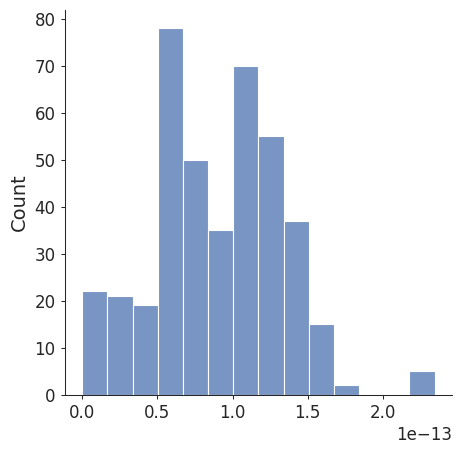

In [7]:
indy = np.where(planes == 0)[0]
ophys_xy = all_roi_raw_center_pts[indy,:]
use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(ophys_xy)
target = copy.deepcopy(source)

# transform target point cloud
th = np.deg2rad(30.0)
target.transform(np.array([[np.cos(th), -np.sin(th), 0.0, 0.0],
                           [np.sin(th), np.cos(th), 0.0, 0.0],
                           [0.0, 0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0, 1.0]]))

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'rigid',use_cuda=use_cuda,maxiter=maxiter,tol=tol)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points) - to_cpu(result.points),axis=1)
sns.histplot(residuals)

In [8]:
# draw result
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0, 1])
o3.visualization.draw_geometries([source, target, result])

<Axes: ylabel='Count'>

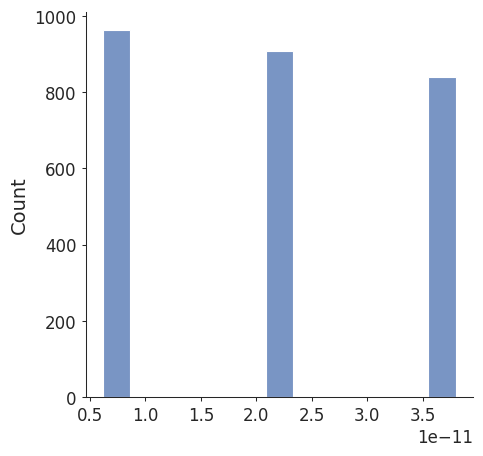

In [9]:

ophys_xy = point_set_2p
use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(ophys_xy)
target = copy.deepcopy(source)

# transform target point cloud
th = np.deg2rad(30.0)
target.transform(np.array([[np.cos(th), -np.sin(th), 0.0, 0.0],
                           [np.sin(th), np.cos(th), 0.0, 0.0],
                           [0.0, 0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0, 1.0]]))

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'affine',use_cuda=use_cuda,maxiter=maxiter,tol=tol)#,beta=10,lmd=1e-5)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points) - to_cpu(result.points),axis=1)
sns.histplot(residuals)

In [11]:
# draw result
source.paint_uniform_color([1, 0, 0]) #Red
target.paint_uniform_color([0, 1, 0]) #Green
result.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([source, target, result])

## Filterreg first, then CPD

<Axes: ylabel='Count'>

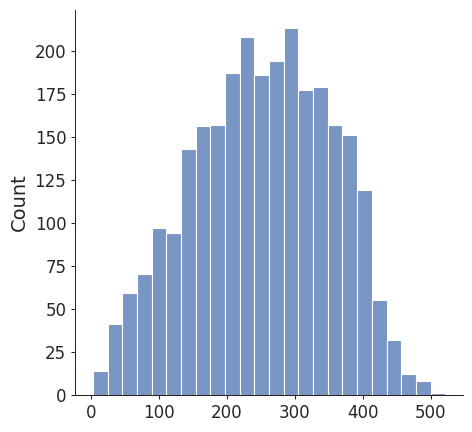

In [11]:

use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_2p)
target = copy.deepcopy(source)

# transform target point cloud
th = np.deg2rad(30.0)
target.transform(np.array([[np.cos(th), -np.sin(th), 0.0, 0.0],
                           [np.sin(th), np.cos(th), 0.0, 0.0],
                           [0.0, 0.0, 1.0, 0.0],
                           [0.0, 0.0, 0.0, 1.0]]))

objective_type = 'pt2pt'
tf_param, _, _ = filterreg.registration_filterreg(source, target,maxiter=maxiter,tol=tol,
                                                  objective_type=objective_type,
                                                  feature_fn=features.FPFH())


result = copy.deepcopy(source)
result.points = tf_param.transform(result.points)

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points) - to_cpu(result.points),axis=1)
sns.histplot(residuals)

In [9]:
source.paint_uniform_color([1, 0, 0])
target.paint_uniform_color([0, 1, 0])
result.paint_uniform_color([0, 0, 1])
o3.visualization.draw_geometries([source, target, result])

In [28]:
maxiter = 10000
cpd_types = ['rigid', 'affine', 'nonrigid', 'nonrigid_constrained']
tf_type = cpd_types[2]

#Cast as open3d point cloud
source = o3d.geometry.PointCloud()
target = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(set_2p)
target.points = o3d.utility.Vector3dVector(set_em)

source_cuda = cp.asarray(set_2p, dtype=cp.float32)
target_cuda = cp.asarray(set_em, dtype=cp.float32)

#Create object and perform registration
# cbs = [callbacks.Open3dVisualizerCallback(source, target)]
reg_obj = registration_cpd(source, target, tf_type_name=tf_type,
                        maxiter=maxiter,tol=1e-9,use_cuda=use_cuda)#, callbacks=cbs) #idx_source=idx_2p, idx_target=idx_em, 



In [ ]:
tf_param = reg_obj.transformation

#Transform EM data
transformed_source = tf_param.transform(source_cuda)

#Get cells that are coregisted
coreg_em = point_set_em[idx_em]
coreg_2p_transformed = to_cpu(transformed_source)

#Plot residuals
residuals = np.linalg.norm(coreg_em - coreg_2p_transformed,axis=1)
sns.histplot(residuals)

In [ ]:

#Create object and perform registration
rcpd = cpd.RigidCPD(source, use_cuda=use_cuda)
tf_param, _, _ = rcpd.registration(target)

#Transform EM data
transformed_source = tf_param.transform(source)

#Get cells that are coregisted
coreg_em = point_set_em[idx_em]
coreg_2p_transformed = to_cpu(transformed_source[idx_2p])

#Plot residuals
residuals = np.linalg.norm(coreg_em - coreg_2p_transformed,axis=1)
sns.histplot(residuals)

## Plot points

In [14]:
vol_thresh = 125
vol_mask = nucleus_vols > vol_thresh
np.sum(vol_mask)


13650

In [13]:
corr_mask_2p = np.zeros((point_set_2p.shape[0]),dtype=bool)
corr_mask_2p[idx_2p] = True

corr_mask_em = np.zeros((point_set_em.shape[0]),dtype=bool)
corr_mask_em[idx_em] = True


In [17]:
coreg_pts_planes =  planes[idx_2p]

In [135]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

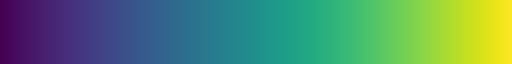

In [12]:
cmap = sns.color_palette("viridis",as_cmap=True)
cmap

In [18]:
point_set_2p_0 = point_set_2p_new - point_set_2p_new[idx_2p[0]]
point_set_em_0 = point_set_em - point_set_em[idx_em[0]]

point_cloud_list = []
# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_2p_new)
source.paint_uniform_color([0.7,0.7,0.7]) #Green
point_cloud_list.append(source)

for i in range(6):
    plane_mask = coreg_pts_planes == i
    mask = idx_2p[plane_mask]
    pc_2p = o3d.geometry.PointCloud(); pc_2p.points = o3d.utility.Vector3dVector(point_set_2p_new[mask])
    pc_2p.paint_uniform_color(cmap(i/6)[:3])
    point_cloud_list.append(pc_2p)

target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_em[vol_mask][::10])
target.paint_uniform_color([0.8,0.8,0.8]) #Green
point_cloud_list.append(target)

for i in range(6):
    plane_mask = coreg_pts_planes == i
    mask = idx_em[plane_mask]
    pc_em = o3d.geometry.PointCloud(); pc_em.points = o3d.utility.Vector3dVector(point_set_em[mask])
    pc_em.paint_uniform_color(cmap(i/6)[:3])
    point_cloud_list.append(pc_em)
    
# draw result

o3.visualization.draw_geometries(point_cloud_list)

In [75]:
point_set_2p_0 = point_set_2p_new - point_set_2p_new[idx_2p[0]]
point_set_em_0 = point_set_em - point_set_em[idx_em[0]]

# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_2p)
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_em)

# draw result
source.paint_uniform_color([1, 0, 0]) #Red
target.paint_uniform_color([0, 1, 0]) #Green
# result.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([source, target])

## CPD on 2p and EM point clouds

<Axes: ylabel='Count'>

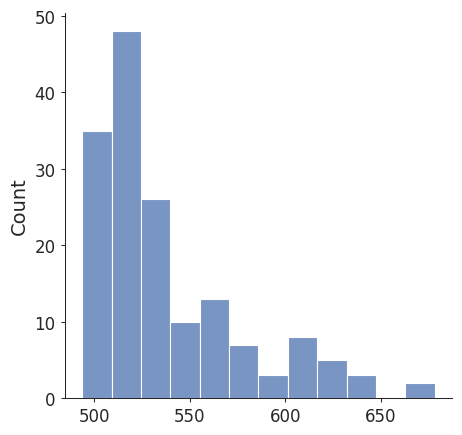

In [61]:
use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_2p[idx_2p])
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_em[idx_em])

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'nonrigid',use_cuda=use_cuda,maxiter=maxiter,tol=tol)#,beta=10,lmd=1e-5)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Get cells that are coregisted
coreg_em = to_cpu(target.points)#[idx_em]
coreg_2p_transformed = to_cpu(result.points)#[idx_2p]

#Plot residuals
residuals = np.linalg.norm(coreg_em - coreg_2p_transformed,axis=1)
sns.histplot(residuals)


<Axes: ylabel='Count'>

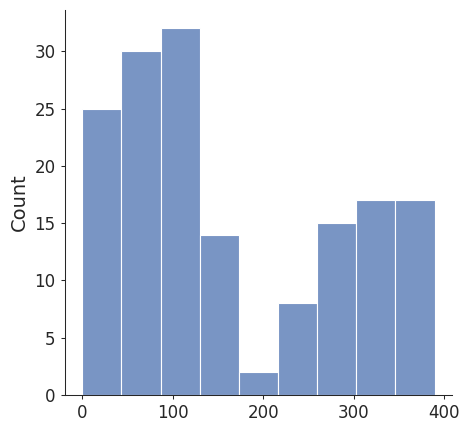

In [33]:
use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
source = copy.deepcopy(result)
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_em[idx_em])

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'nonrigid',use_cuda=use_cuda,maxiter=maxiter,tol=tol,beta=10,lmd=1e-5)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Get cells that are coregisted
coreg_em = to_cpu(target.points)#[idx_em]
coreg_2p_transformed = to_cpu(result.points)#[idx_2p]

#Plot residuals
residuals = np.linalg.norm(coreg_em - coreg_2p_transformed,axis=1)
sns.histplot(residuals)


In [60]:
# draw result
source.paint_uniform_color([1, 0, 0]) #Red
target.paint_uniform_color([0, 1, 0]) #Green
result.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([source, target, result])

## Non-rigid CPD

<Axes: ylabel='Count'>

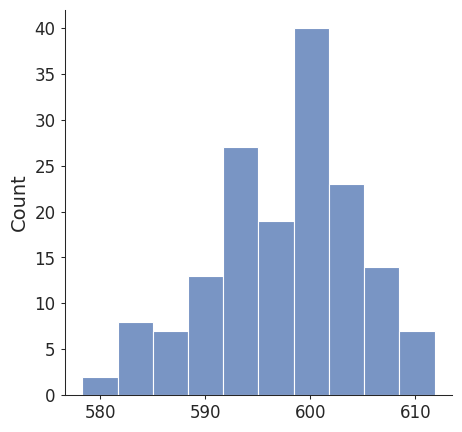

In [11]:
maxiter = 10000
#Cast cuda array
source = cp.asarray(point_set_2p_new, dtype=cp.float32)
target = cp.asarray(point_set_em, dtype=cp.float32)

#Open 3D format
source_03d = o3d.geometry.PointCloud(); source_03d.points = o3d.utility.Vector3dVector(point_set_2p_new)
target_03d = o3d.geometry.PointCloud(); target_03d.points = o3d.utility.Vector3dVector(point_set_em)

#Create object and perform registration
acpd = cpd.NonRigidCPD(source, use_cuda=use_cuda)
tf_param, _, _ = acpd.registration(target,maxiter=maxiter)

#Transform EM data
transformed_source = tf_param.transform(source)

#Get cells that are coregisted
coreg_em = point_set_em[idx_em]
coreg_2p_transformed = to_cpu(transformed_source[idx_2p])

#Plot residuals
residuals = np.linalg.norm(coreg_em - coreg_2p_transformed,axis=1)
sns.histplot(residuals)

In [12]:
pc = o3.geometry.PointCloud()
pc.points = o3.utility.Vector3dVector(to_cpu(transformed_source))
pc.paint_uniform_color([1, 0.5, 0])
target_03d.paint_uniform_color([0, 0, 1])

o3.visualization.draw_geometries([pc, target_03d])

## Constrained non-rigid CPD

In [76]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
t0, t1 = kf.split(idx_2p)
train_indy = t0[0]; test_indy = t1[0]
train_indy

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159])

In [77]:
point_set_2p_0 = point_set_2p_new - point_set_2p_new[idx_2p[0]]
point_set_em_0 = point_set_em - point_set_em[idx_em[0]]

# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_2p)
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_em)

# draw result
source.paint_uniform_color([1, 0, 0]) #Red
target.paint_uniform_color([0, 1, 0]) #Green
# result.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([source, target])

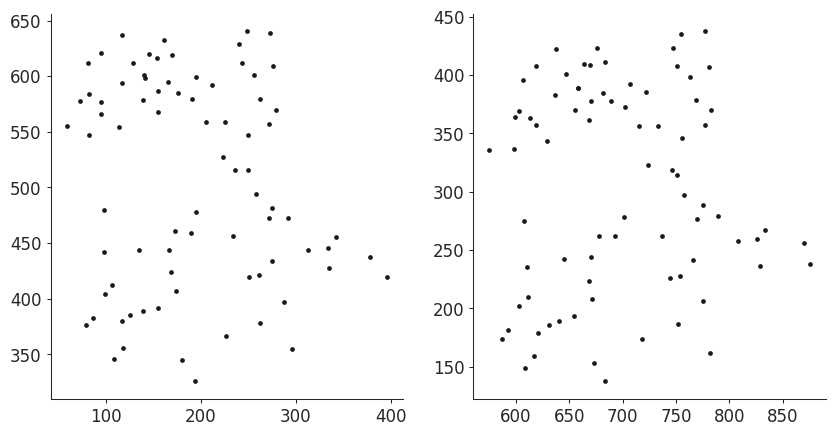

In [25]:
# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_2p_new)
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_em)
idx_source=idx_2p[train_indy];
idx_target=idx_em[train_indy]



fig, axes = plt.subplots(1,2,figsize=(10,5))
tmp = np.asarray(source.points)[idx_source]
axes[0].plot(tmp[:,0],tmp[:,2],'.k')

tmp = np.asarray(target.points)[idx_target]
axes[1].plot(tmp[:,0],tmp[:,2],'.k')

<Axes: ylabel='Count'>

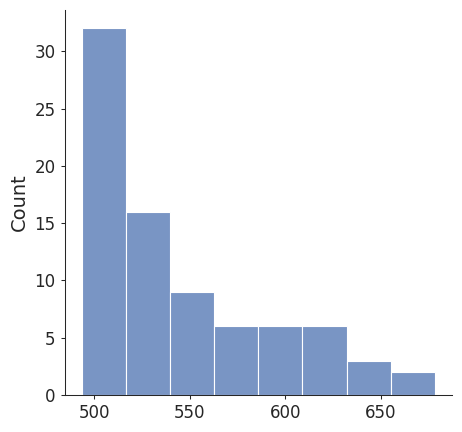

In [78]:
use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_2p)
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_em)

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'nonrigid_constrained',use_cuda=use_cuda,maxiter=maxiter,tol=tol,idx_target=idx_2p[train_indy],idx_source=idx_em[train_indy])#,beta=1000,lmd=100)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Get cells that are coregisted
# coreg_em = to_cpu(target.points)[idx_em[test_indy]]
# coreg_2p_transformed = to_cpu(result.points)[idx_em[test_indy]]

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points)[idx_2p[test_indy]] - to_cpu(result.points)[idx_em[test_indy]],axis=1)
sns.histplot(residuals)


<Axes: ylabel='Count'>

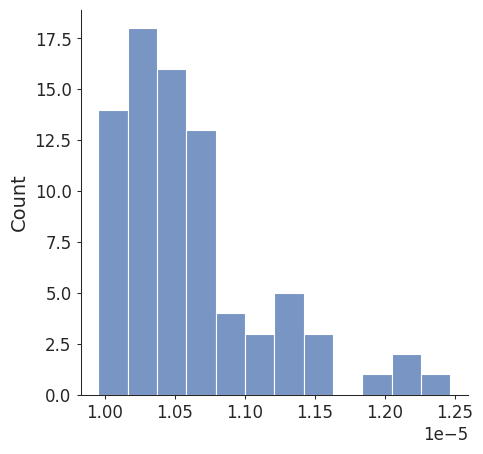

In [79]:

#Plot residuals
residuals = np.linalg.norm(to_cpu(target.points)[idx_2p[train_indy]] - to_cpu(result.points)[idx_em[train_indy]],axis=1)
sns.histplot(residuals)


In [91]:
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_2p)
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_em)

source.paint_uniform_color([0.7,0.7,0.7]) 
result_train = o3d.geometry.PointCloud(); result_train.points = o3d.utility.Vector3dVector(np.asarray(result.points)[idx_2p[train_indy]]); result_train.paint_uniform_color([1,0,0]) #
result_test = o3d.geometry.PointCloud(); result_test.points = o3d.utility.Vector3dVector(np.asarray(result.points)[idx_2p[test_indy]]); result_test.paint_uniform_color([0,1,0]) #

target2 = o3d.geometry.PointCloud(); target2.points = o3d.utility.Vector3dVector(point_set_2p)
target2.paint_uniform_color([0.8,0.8,0.8]) #

result.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([source, target2,result])#result_train, result_test])

In [87]:
np.asarray(source.points)

array([[573.7748863 , 551.890883  , 375.615     ],
       [940.12394139, 632.05189506, 271.755     ],
       [947.4959425 , 623.05089371, 263.61      ],
       ...,
       [631.58689499, 493.14787417, 133.2       ],
       [585.56988807, 452.64086808, 101.97      ],
       [600.15889026, 710.81590691,  96.93      ]])

In [86]:
np.asarray(target.points)

array([[343.09136814, 271.41003318, 267.        ],
       [204.63698408, 367.63960062, 267.        ],
       [308.11094224, 511.19133076, 267.        ],
       ...,
       [271.85200643, 472.16321342, 347.        ],
       [268.46148938, 518.98142647, 347.        ],
       [292.83549557, 595.23691647, 347.        ]])

<Axes: ylabel='Count'>

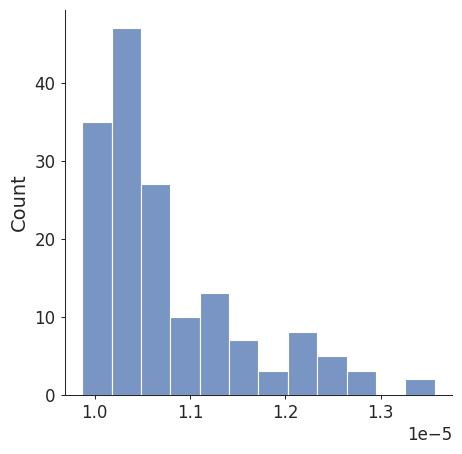

In [34]:
use_cuda = False; maxiter = 10000; tol = 1e-6

# cast as point clouds
source = o3d.geometry.PointCloud(); source.points = o3d.utility.Vector3dVector(point_set_2p)
target = o3d.geometry.PointCloud(); target.points = o3d.utility.Vector3dVector(point_set_em)

# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(source, target,'nonrigid_constrained',use_cuda=use_cuda,maxiter=maxiter,tol=tol,idx_source=idx_2p,idx_target=idx_em)#,alpha=0.1,beta=100)#,lmd=1e-5)

if use_cuda:
    source_pre_transform = cp.asarray(source.points)
    tmp = tf_param.transform(source_pre_transform)
    result = o3d.geometry.PointCloud(); result.points = o3d.utility.Vector3dVector(tmp.get())
else:
    result = copy.deepcopy(source)
    result.points = tf_param.transform(result.points)

#Get cells that are coregisted
coreg_em = to_cpu(target.points)[idx_em]
coreg_2p_transformed = to_cpu(result.points)[idx_2p]

#Plot residuals
residuals = np.linalg.norm(coreg_em - coreg_2p_transformed,axis=1)
sns.histplot(residuals)


In [37]:
tf_param.g.shape

(2710, 2710)

In [31]:

# cast as point clouds
co_2p = o3d.geometry.PointCloud(); co_2p.points = o3d.utility.Vector3dVector(point_set_2p[idx_2p])
co_2p_transformed = o3d.geometry.PointCloud(); co_2p_transformed.points = o3d.utility.Vector3dVector(coreg_2p_transformed)
co_em = o3d.geometry.PointCloud(); co_em.points = o3d.utility.Vector3dVector(point_set_em[idx_em])

co_2p.paint_uniform_color([1, 0, 0]) #Red
co_2p_transformed.paint_uniform_color([0, 1, 0]) #Green
co_em.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([co_2p, co_2p_transformed, co_em])

In [41]:
# draw result
source.paint_uniform_color([0.7,0.7,0.7]) #Blue
target.paint_uniform_color([0, 1, 0]) #Green
target2 = o3d.geometry.PointCloud(); target2.points = o3d.utility.Vector3dVector(point_set_em[::10])
target2.paint_uniform_color([0.8,0.8,0.8]) #Blue

result.paint_uniform_color([0, 0, 1]) #Blue
o3.visualization.draw_geometries([source, target2, result])

In [14]:
pc = o3.geometry.PointCloud()
pc.points = o3.utility.Vector3dVector(to_cpu(transformed_source))
pc.paint_uniform_color([1, 0.5, 0])
target_03d.paint_uniform_color([0, 0, 1])

o3.visualization.draw_geometries([pc, target_03d])

## PyPCD

In [8]:

from pycpd import RigidRegistration
from functools import partial
def visualize(iteration, error, X, Y, ax):
    plt.cla()
    ax.scatter(X[:, 0],  X[:, 1], X[:, 2], color='red', label='Target')
    ax.scatter(Y[:, 0],  Y[:, 1], Y[:, 2], color='blue', label='Source')
    ax.text2D(0.87, 0.92, 'Iteration: {:d}\nQ: {:06.4f}'.format(
        iteration, error), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize='x-large')
    ax.legend(loc='upper left', fontsize='x-large')
    plt.draw()
    plt.pause(0.001)

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# callback = partial(visualize, ax=ax)

reg = RigidRegistration(X=point_set_2p_new[idx_2p], Y=point_set_em[idx_em])
TY, parameters = reg.register()


In [10]:
point_set_em[idx_em]

array([[686.29490322, 542.26888156, 193.77      ],
       [723.61990883, 553.67588327, 184.365     ],
       [781.66491756, 598.21888997,  69.93      ],
       [841.1069265 , 591.15688891, 110.43      ],
       [887.12293342, 586.03488814, 127.035     ],
       [912.96393731, 602.71889065, 128.88      ],
       [892.24493419, 596.20088967, 148.32      ],
       [842.34792669, 615.75589261, 128.07      ],
       [833.81192541, 601.24489043, 133.425     ],
       [705.22890607, 569.8168857 , 189.135     ],
       [690.32990383, 559.80688419, 203.76      ],
       [659.98789926, 550.88288285, 212.04      ],
       [748.37491256, 564.85088495, 208.845     ],
       [853.67792839, 630.73289486,  92.7       ],
       [763.9719149 , 628.01689445,  75.555     ],
       [651.29689796, 614.3588924 ,  78.12      ],
       [782.20791764, 574.16288635, 224.325     ],
       [729.05190965, 575.48188655, 223.335     ],
       [737.97591099, 600.15889026, 197.595     ],
       [692.89090421, 592.55388

In [11]:
TY

array([[183.80862972, 261.85673364, 396.01560597],
       [223.93782562, 267.29524663, 384.0550809 ],
       [289.00285804, 270.561814  , 256.91419595],
       [350.56430988, 271.79157934, 301.49187382],
       [398.31003797, 268.36562812, 321.11631832],
       [426.79705739, 283.58238036, 318.40550548],
       [404.4479723 , 284.93105121, 339.34963705],
       [353.86140883, 301.91067852, 311.35658939],
       [343.67056966, 289.80557323, 321.09747289],
       [205.9938369 , 286.39335279, 383.14494625],
       [189.4725762 , 282.25370393, 400.55018827],
       [156.87775455, 278.38432799, 410.79751794],
       [250.73109702, 284.34375409, 405.74583846],
       [367.14279934, 304.64944802, 271.47898944],
       [272.93518575, 303.51858576, 252.52610252],
       [153.64657676, 299.58177162, 256.13234525],
       [286.92188565, 295.93392599, 419.28147289],
       [231.30727405, 301.12479847, 416.30328629],
       [242.84237979, 316.82484616, 382.90934985],
       [194.98642269, 308.76323